In [145]:
import math
import time
import json
import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from numpy import cos, sin, arcsin, sqrt
%matplotlib inline
plt.figure(figsize=(20,5))
PALETTE = ["#FFC30D", "#EF404B"]
PALETTE_ALT = ["#40EFE4", "#EF404B"]

<Figure size 1440x360 with 0 Axes>

In [18]:
df = pd.read_pickle('../data/shippify_icd_new.pkl', compression='gzip')
df = df.dropna(subset=['pickup_effective_dt', 'delivery_effective'])
#df.info()

In [ ]:
df.info()

### **Agregar codigo necesario debajo de su nombre**

## Enmanuel Magallanes

In [105]:
def set_labels(title=None, x_label=None, y_label=None, fontsize=14, legend=None):
  if title is not None:
    plt.title(title, fontsize=fontsize)
  if x_label is not None:
    plt.xlabel(x_label, fontsize=fontsize)
  if y_label is not None:
    plt.ylabel(y_label, fontsize=fontsize)
  if legend is not None:
    legend['object'].set_title(legend['title'])
    for t, l in zip(legend['object'].texts, legend['texts']): t.set_text(l)

def with_hue(plot, feature, categories, hue_categories, diff=False):
  a = [p.get_height() for p in plot.patches]
  patch = [p for p in plot.patches]
  for i in range(categories):
    total = a[i] + a[i+categories]
    difference = []
    for j in range(hue_categories):
      value = round(100 * a[(j*categories + i)]/total, 2)
      percentage = '{:.1f}%'.format(value)
      x = patch[(j*categories + i)].get_x() + patch[(j*categories + i)].get_width() / 2 - 0.15
      y = patch[(j*categories + i)].get_y() + patch[(j*categories + i)].get_height() 
      plt.annotate(percentage, (x, y), size = 12)
      if diff:
        difference.append(value)
    if diff:
      print('{0:8s}: |{1:>5} - {2:>5}| = {3:>5}'.format(feature[i], difference[0], difference[1], abs(round(difference[0]-difference[1], 2))))
    #print(f'{feature[i]}: {difference[0]} - {difference[1]} = {abs(round(difference[0]-difference[1], 2))}')
  plt.show()
  
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

## Question: Is the total weight of packages a factor affecting the timeliness of deliveries?

In [ ]:
def sum_total_weight(row):
  items = json.loads(row)
  total_weight = 0
  for item in items:
    try:
      weigth = item['weight']
      if weigth == 'NaN':
        total_weight += 0
      else:
        total_weight += float(weigth)
    except:
      total_weight += 0
  return total_weight
df['total_weight'] = df['items'].apply(sum_total_weight)

# Remove outlayers using the z-score
z_scores = stats.zscore(df['total_weigth'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 3
df = df[ filtered_entries ]

labels = ['[0,0.5) kg', '[0.5,1) kg', '[1,1.5) kg', '[1.5,2) kg', '[2,2.5) kg', '[2.5,3) kg', '[3,3.5) kg', '[3.5 kg,inf) kg']
#df['class_weight'] = pd.cut(df['total_weight'], bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, np.inf], labels=labels, include_lowest=True)

In [20]:
#Rename type of size packages to be more readable
size_dict = { 1: 'X Small', 2: 'Small', 3: 'Medium', 4: 'Large', 5: 'X Large' }
df['total_size'] = df['total_size'].apply(lambda size: size_dict.get(size, 3))

#Add column with total of task in this city
df['total_task'] = len(df)

# Add column to mark task that was deliveried with delay
df['is_late'] = df['delivery_dt'] < df['delivery_effective']

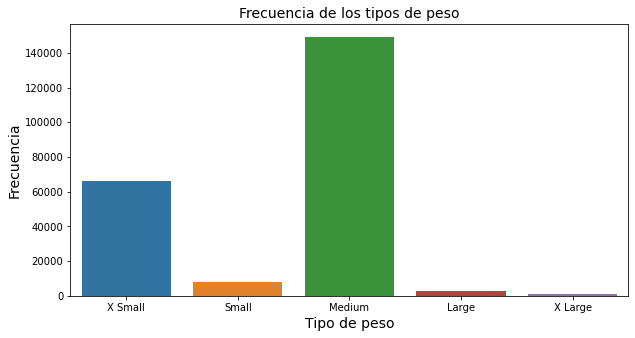

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='total_size', order=size_dict.values())
set_labels('Frecuencia de los tipos de peso', 'Tipo de peso', 'Frecuencia')

X Small : |45.86 - 54.14| =  8.28
Small   : |49.41 - 50.59| =  1.18
Medium  : |23.47 - 76.53| = 53.06
Large   : |13.29 - 86.71| = 73.42
X Large : |31.04 - 68.96| = 37.92


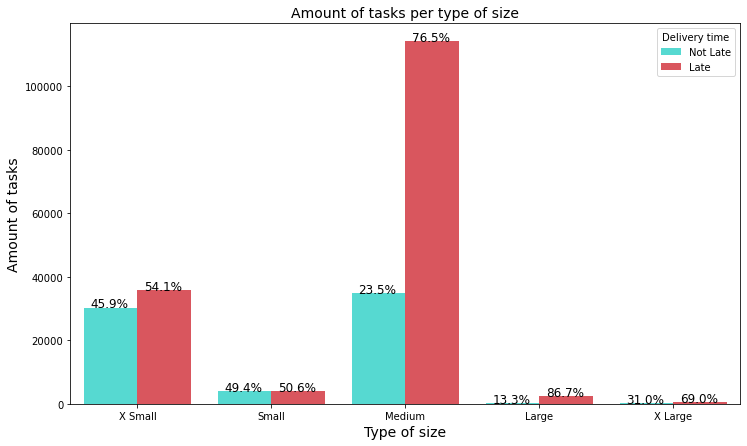

In [146]:
gsl = df[['id', 'total_size', 'is_late']].groupby(['total_size', 'is_late'])['id'].count().reset_index()
plt.figure(figsize=(12,7))
plt.tight_layout()
f = sns.barplot(data=gsl, x='total_size', y='id', hue='is_late', order=size_dict.values(), palette=PALETTE_ALT)

set_labels(
  'Amount of tasks per type of size', 'Type of size', 'Amount of tasks', 
  legend={'object': f.get_legend(), 'title': 'Delivery time', 'texts': ['Not Late', 'Late']
})
with_hue(f, list(size_dict.values()), 5, 2, diff=True)

In the graph we can see that there are more deliveries with size X Small and Medium than the others. However, what is important here is to analyze the percentage of tasks delivered on time and those that are not. There are no significant differences between Small and Small X-size tasks. In contrast, Medium, Large and X Large tasks have a significant difference in the percentage of on-time deliveries. This indicates that the size of deliverables affects on-time delivery when their size is equal to or larger than Medium.

### Question 2: La intensidad del trafico en el punto destino de una entrega influje en la puntualidad de la misma?

Definimos a entregas vecinas a todas aquellas entregas que están a una distancia menor o igual a X KM de la misma y su fecha de entrega este dentro de T horas de la misma.

### Question 3: Son las tareas con menos cantidad de entregas vecinas las que demoran mas en llegar a su punto de entrega?

In [49]:
# We will group deliveries by route ID, to get the average distance and time from the first delivery to the last delivery. 
# With these values we will obtain distance and time ranges to find the route density.
def haversine_distance(x, y):
  lon1, lat1, lon2, lat2 = map(math.radians, [x[0], x[1], y[0], y[1]])
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
  c = 2 * math.asin(sqrt(a))
  return R * c

def generate_combinations(points):
  combinations = []
  for i in range(len(points)):
    for j in range(i+1, len(points)):
      combinations.append([points[i], points[j]])
  return combinations

def calculate_time(group):
  min_dt = group['delivery_dt'].min()
  max_dt = group['delivery_dt'].max()
  return (max_dt - min_dt).total_seconds() / 3600

def calculate_distance(group):
  group = group.set_index('delivery_dt')
  group = group.sort_values('delivery_dt')
  center = (group['long'].mean(), group['lat'].mean())
  return np.array(group.apply(lambda r: haversine_distance((r.long, r.lat), center), axis=1)).mean()

gr_hours = df.groupby('route_id').apply(calculate_time)
gr_distance = df.groupby('route_id').apply(calculate_distance)

Mean time from first delivery to the last delivery: 3.12 hours


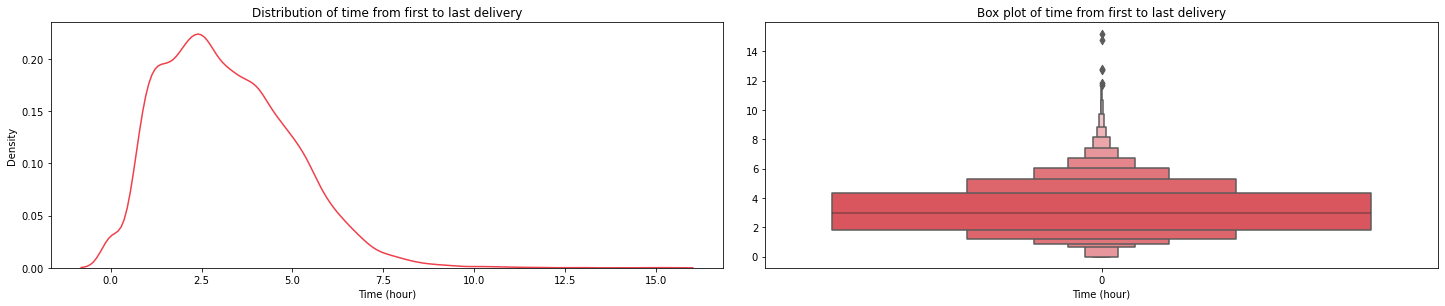

In [141]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of time from first to last delivery')
ax[0].set_xlabel('Time (hour)')
sns.kdeplot(data=gr_distance, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of time from first to last delivery')
ax[1].set_xlabel('Time (hour)')
sns.boxenplot(data=gr_distance, ax=ax[1], color=PALETTE[1])

print('Mean time from first delivery to the last delivery: {0:.2f} hours'.format(gr_hours.mean()))

Mean distance first delivery to the last delivery: 3.20 km


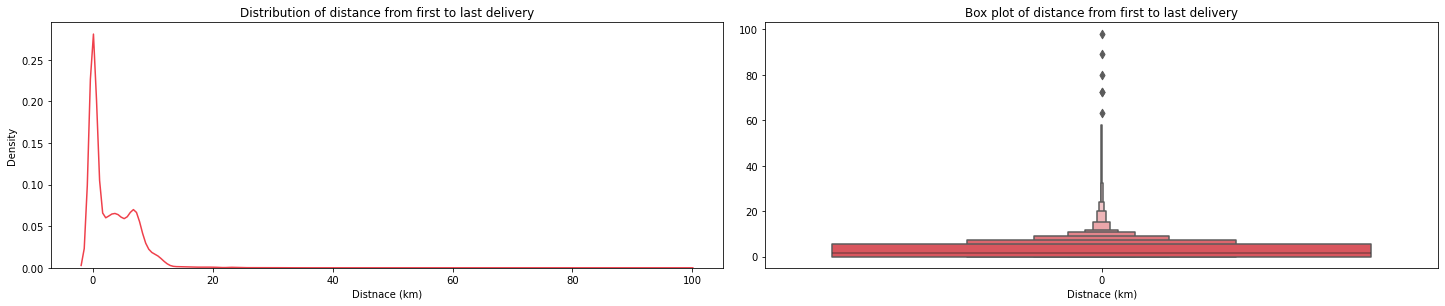

In [144]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of distance from first to last delivery')
ax[0].set_xlabel('Distnace (km)')
sns.kdeplot(data=gr_hours, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of distance from first to last delivery')
ax[1].set_xlabel('Distnace (km)')
sns.boxenplot(data=gr_hours, ax=ax[1], color=PALETTE[1])
print('Mean distance first delivery to the last delivery: {0:.2f} km'.format(gr_distance.mean()))

As we can see the scheduled time from the first delivery to the last delivery, on average, is 3.12 hours and the distance, on average, is 3.20 km. These values will be our time window and radius to use to determine the number of deliveries that exist around one

In [12]:
def task_around(row, inner):
  diffs = (row['delivery_dt'] - inner['delivery_dt'])
  diffs = np.abs(diffs.dt.total_seconds()) / 3600
  inner = inner[ diffs <= WINDOW_TIME ]
  distances = inner.apply(
    lambda pt: haversine_distance((pt['long'], pt['lat']), (row['long'], row['lat'])),
    axis=1
  )
  return len(inner[ distances <= KMS_AROUND ])

R = 6371
KMS_AROUND = 3.20
WINDOW_TIME = 3.12
task_around = df.apply(lambda r: task_around(r, df.copy()), axis=1)

In [15]:
df['task_around_5'] = task_around

In [16]:
df.to_pickle("../data/shippify_icd_task5.pkl", compression='gzip')

### Hour late vs Total weight

In [ ]:
diff = df['delivery'] - df['delivery_effective']
df['delay_delivery'] = diff.apply(lambda x: abs(int(x.total_seconds()))) / 3600

## Josue Cobos

In [ ]:
#Question: Are those deliveries that are further from the economic center of Belo Horizonte those with the longest delivery delay?

In [ ]:
#calculate distance between 2 lat long points
def calculateDistance(point, anotherPoint):
    lat1, lon1 = point
    lat2, lon2 = anotherPoint 
    R = 6373.0
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance #kilometers

In [ ]:
#For this question we will assume Barreiro in the most important regional administration of Belo Horizonte
BARREIROPOINT = (-19.977, -44.0145)
def getDistanceFromA(row):
  #print(row)
  return calculateDistance(BARREIROPOINT, (row['lat'], row['long']))
  #return row #distance

In [ ]:
df['dst_to_barreiro'] = df[['lat', 'long']].apply(getDistanceFromA, axis=1)

In [ ]:
plt.figure(figsize=(15,7))
subdf = df[['dst_to_barreiro','delay_delivery']]
f2 = sns.scatterplot(x=subdf['dst_to_barreiro'], y=subdf['delay_delivery'])
#with_hue(f, df.class_weight, 8, 2)

In [ ]:
subdf.corr()

In [ ]:
#Answer: Due to the non-existent correlation between the delay of shipments (delay_delivery) and distance to Barreiro (dst_to_barreiro), we can conclude that no matter how far your order is, it does not necessarily mean that it has a longer delay time.